In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from lmfit import Model
import seaborn as sns
from matplotlib import rcParams
import matplotlib as mpl

In [7]:
gaussian_df = pd.read_csv('https://raw.githubusercontent.com/ggdna/scScaling/main/results/Caltech101_Gaussian.csv')
res_df = pd.read_csv('https://raw.githubusercontent.com/ggdna/scScaling/main/results/Caltech101_resolution.csv')
classes = sorted(gaussian_df[gaussian_df['N instances of label'] > 100]['Class label'].unique())
class_names = ['Faces1', 'Faces2', 'Motorbikes', 'Airplanes', 'Watches', 'All']
gaussian_df['Scale'] = gaussian_df['Scale']**2
res_df['Factor'] = res_df['Factor']

df = pd.read_csv('https://raw.githubusercontent.com/igor-sadalski/Scaling-up-measurement-noise-scaling-laws/main/collect_mi_results.csv')
df.replace('celltype.l3', 'Cell type MI', inplace=True)
df.replace('protein_counts', 'Protein MI', inplace=True)
df.replace('clone', 'Clonal MI', inplace=True)
df.replace('author_day', 'Temporal MI', inplace=True)
df.replace('ng_idx', 'Spatial MI', inplace=True)
df.replace('RandomProjection', 'Rand. Proj.', inplace=True)
# df = df[df['signal'] != 'Cell type MI']

sc_param_df = pd.read_csv('analysis/final_results/cell_scaling_N0_21733.759_s_0.502_I_inf_2.927_I_0_0.730.csv')
sc_param_df.replace('celltype.l3', 'Cell type MI', inplace=True)
sc_param_df.replace('protein_counts', 'Protein MI', inplace=True)
sc_param_df.replace('clone', 'Clonal MI', inplace=True)
sc_param_df.replace('author_day', 'Temporal MI', inplace=True)
sc_param_df.replace('ng_idx', 'Spatial MI', inplace=True)
sc_param_df.replace('RandomProjection', 'Rand. Proj.', inplace=True)

sc_param_df_noise = pd.read_csv('analysis/final_results/scaling_plots_u_bar_138.109_I_max_1.419.csv')
sc_param_df_noise.replace('celltype.l3', 'Cell type MI', inplace=True)
sc_param_df_noise.replace('protein_counts', 'Protein MI', inplace=True)
sc_param_df_noise.replace('clone', 'Clonal MI', inplace=True)
sc_param_df_noise.replace('author_day', 'Temporal MI', inplace=True)
sc_param_df_noise.replace('ng_idx', 'Spatial MI', inplace=True)
sc_param_df_noise.replace('RandomProjection', 'Rand. Proj.', inplace=True)

def cell_number_scaling(x, N0, s, I_inf):
    """
    Cell number scaling function: I(x) = max(I_0, I_inf - (x / N0) ** (-s))
    """
    I_0 = 0
    with np.errstate(divide="ignore", invalid="ignore", over="ignore"):
        # Calculate the scaling term more safely to avoid overflow
        ratio = x / N0
        # Use log-space calculation to avoid overflow
        scaling_term = np.where(
            ratio > 0,
            np.exp(-s * np.log(ratio)),
            0.0
        )
        result = np.where(x > 0, np.maximum(I_0, I_inf - scaling_term), np.nan)
    return result

def info_scaling(u, u_bar, I_max):
    """
    Information scaling function based on:
        I(u) = I_max - 0.5 * log2( (1 + u/u_bar) / (u/u_bar + 2**(-2*I_max)) )
    """
    # Avoid division by zero and invalid values
    u = np.asarray(u)
    u_bar = np.asarray(u_bar)
    I_max = np.asarray(I_max)
    # Set a small epsilon to avoid division by zero
    epsilon = 1e-12
    u_bar_safe = np.where(u_bar == 0, epsilon, u_bar)
    u_over_u_bar = u / u_bar_safe
    numerator = 1 + u_over_u_bar
    denominator = u_over_u_bar + 2 ** (-2 * I_max)
    # Avoid division by zero in denominator
    denominator = np.where(denominator == 0, epsilon, denominator)
    # Avoid negative or zero values inside log2
    ratio = numerator / denominator
    ratio = np.where(ratio <= 0, epsilon, ratio)
    return I_max - 0.5 * np.log2(ratio)

In [8]:
sns.set_style('whitegrid')
rcParams['figure.dpi'] = 150
rcParams['figure.figsize'] = (4, 3)
rcParams['grid.linewidth'] = 0.5
rcParams['grid.linestyle'] = 'dashed'
rcParams['legend.fancybox'] = False
rcParams['mathtext.fontset'] = 'stix'
dpi = 150

In [9]:
c6 = ['#c4bae2','#40ada6','#3c4ebf',
        '#e3a600', '#d6543a', '#edb1a3']
pretty_palette = [c6[c] for c in range(6) if c in [1,2,3,4]]
hue_order = ['Rand. Proj.', 'PCA', 'SCVI', 'Geneformer']

pretty_palette_metrics = ["#C85158",
                    "#62A48F",
                    "#475A7A",
                    "#503A38",
                    "#E9AD97",
                    "#88A4BA",]
hue_order_metrics = ['Protein MI', 'Clonal MI', 'Temporal MI', 'Spatial MI', 'Caltech101-binary']


In [10]:
df['signal'].unique()

array(['Cell type MI', 'Protein MI', 'Clonal MI', 'Spatial MI',
       'Temporal MI'], dtype=object)

plotting pre-computed scaling data... go!
Plotted 53 curves.
plotting pre-computed noise data... go!
fitting and plotting for Caltech101-binary...
fitting and plotting for Caltech101-binary...


/tmp/ipykernel_176429/2438699795.py:505: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


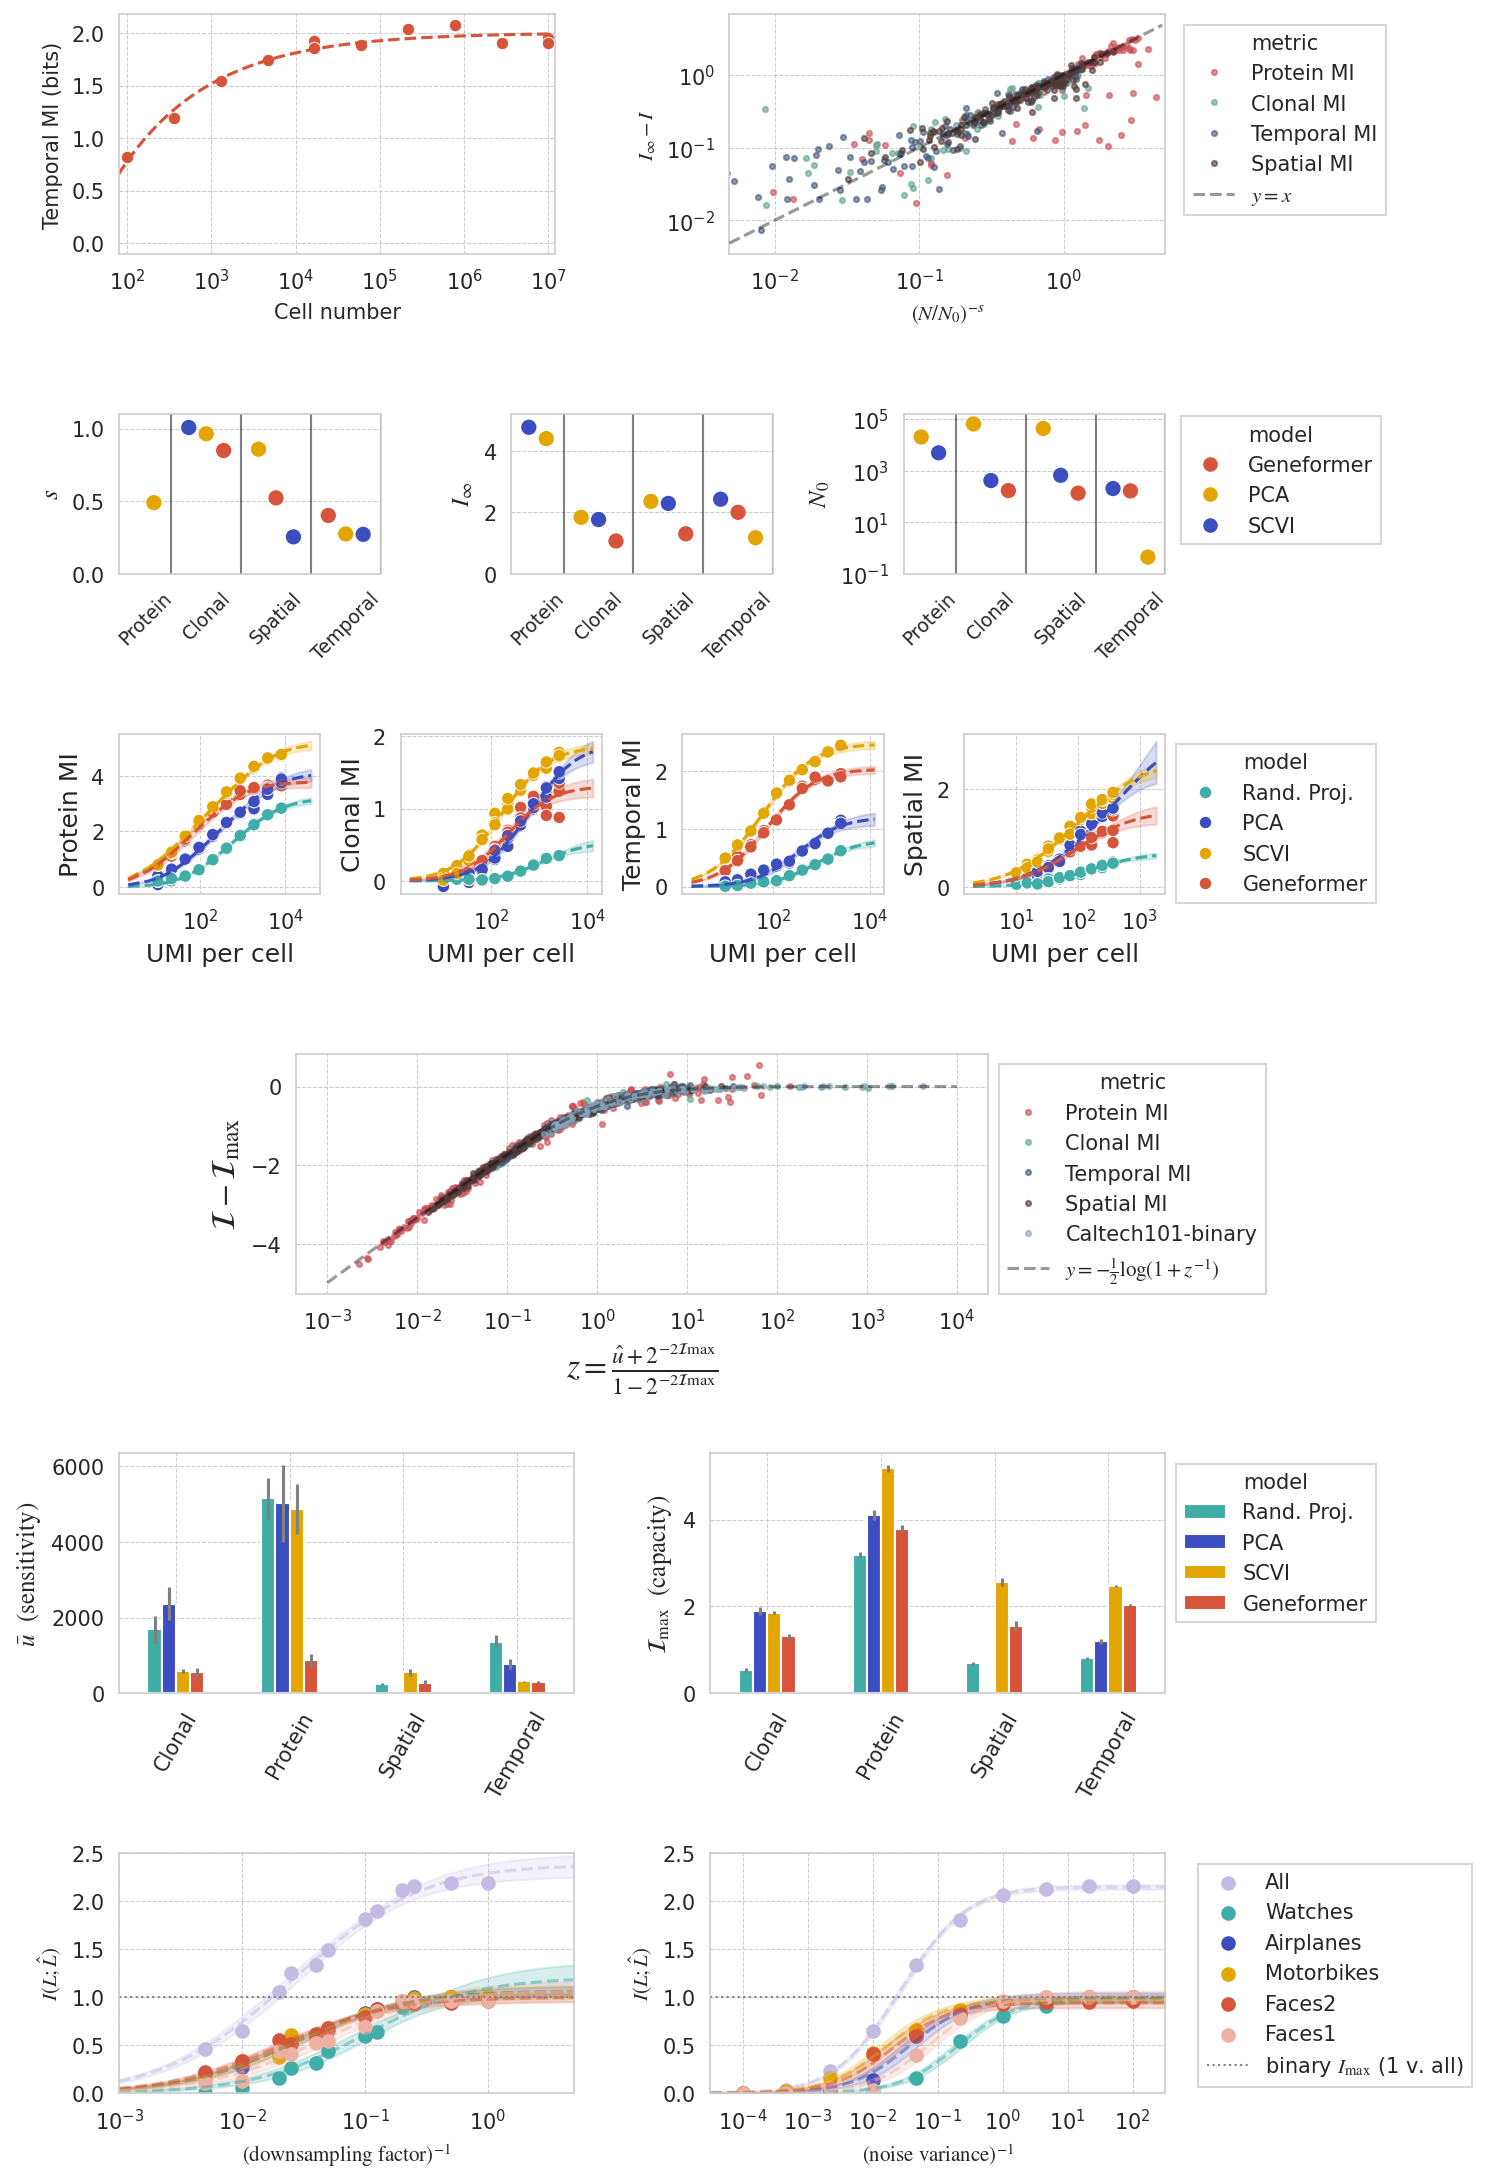

In [20]:
def plot_points(ax, x, y, color, label):
    """plots points! simple. :)"""
    ax.plot(x, y, color=color, marker='o', alpha=0.6, ms=2.5, label=label, lw=0)

def plot_fit(ax, x, y, color):
    """plots a nice fit line"""
    ax.plot(x, y, color=color, linestyle='--', alpha=0.5, lw=0.75, zorder=0.5)

def transform_to_z(x, xbar, imax):
    """the magic z-transform!"""
    A = 2**(-2*imax)
    z = ((x/xbar)+A)/(1-A)
    return z

def info_scaling(x, A, B):
    """the info scaling model"""
    return 0.5 * np.log2((x*B+ 1)/(1+A*x))

def plot_precomputed_scaling(ax, df, param_df, palette):
    """plots data for panel b, the scaling collapse :)"""
    print('plotting pre-computed scaling data... go!')
    hue_order = ['PCA', 'Geneformer', 'SCVI']
    n_curves = 0
    N_hats = []

    for idx, sig in enumerate(hue_order_metrics):
        for q in df['quality'].unique():
            for alg in hue_order:
                data = df[(df['signal'] == sig) & (df['quality'] == q) & (df['algorithm'] == alg)]
                if len(data) < 10: continue
                if q < 0.1: continue

                avg_data = data.groupby('size').mi_value.mean()
                x, y = avg_data.index, avg_data.values

                p = param_df[(param_df['metric'] == sig) & (param_df['method'] == alg) & (param_df['quality'] == q)]
                if p.empty: continue
                
                s = p['s'].values[0]
                N0 = p['N0'].values[0]
                I_inf = p['I_inf'].values[0]

                N_hat = (x/N0)**-s

                # remove if n_hat > i_inf
                mask = N_hat < I_inf
                N_hat = N_hat[mask]
                y = y[mask]

                plot_points(ax, N_hat, I_inf-y, palette[idx], sig)
                if len(y) > 0:
                    n_curves += 1
                N_hats.append(N_hat)

                if np.min(N_hat) < 10**-5:
                    print(f'Warning: N_hat < 1 for {sig}, {alg}, quality {q}')

    # clip x-axis
    q=1
    xs = np.logspace(np.log10(np.percentile(np.concatenate(N_hats), q)), 
                    np.log10(1.1*np.max(np.concatenate(N_hats))), 100)
    ax.plot(xs, xs, color='black', linestyle='--', alpha=0.4, lw=1.5,
         label=r'$y = x$',zorder=10)
    ax.set_xlim(left=np.percentile(np.concatenate(N_hats), q))

    print(f'Plotted {n_curves} curves.')

def plot_precomputed_noise(ax, df, param_df, palette, plot_fits=False):
    """plots data for panel e, the noise collapse!"""
    print('plotting pre-computed noise data... go!')
    hue_order = ['PCA', 'SCVI', 'Geneformer']

    # loop through all our datasets
    for idx, sig in enumerate(hue_order_metrics):
        for size in df['size'].unique():
            for alg in hue_order:
                # grab the right chunk of data
                data = df[(df['signal'] == sig) & (df['size'] == size) & (df['algorithm'] == alg)]
                if len(data) < 10: continue

                avg_data = data.groupby('umis_per_cell').mi_value.mean()
                x, y = avg_data.index, avg_data.values

                # find the magic parameters!
                p = param_df[(param_df['metric'] == sig) & (param_df['method'] == alg) & (param_df['size'] == size)]
                if p.empty: continue
                
                xbar, imax = p['fitted_u_bar'].values[0], p['fitted_I_max'].values[0]
                xbar_err, imax_err = p['u_bar_error'].values[0], p['I_max_error'].values[0]

                # skip if errors are wonky
                if not (xbar_err < xbar and imax_err < imax): continue

                # normalize and plot!
                z = transform_to_z(x, xbar, imax)
                plot_points(ax, z, y-imax, palette[idx], sig)

def fit_and_plot(ax, df, x_col, color, label, plot_fits=False):
    """fits the model on the fly and plots the results."""
    print(f'fitting and plotting for {label}...')

    for class_label in df['Class label'].unique()[:-1]:
        data = df[df['Class label'] == class_label]
        x_data, y_data = 1 / data[x_col], data['MI']

        # set up and run the model fit
        model = Model(info_scaling)
        params = model.make_params(a=1e-2, b=1e-2)
        params['A'].min = 0
        params['B'].min = 0
        result = model.fit(y_data, params, x=x_data)
        
        # check if the fit is reasonable
        a, b = result.params['A'], result.params['B']
        if a.stderr is not None and b.stderr is not None and a.stderr < a.value and b.stderr < b.value:
            x_bar = 1 / a.value
            i_max = 0.5 * np.log2(b.value / a.value)

            # normalize and plot!
            z = transform_to_z(x_data, x_bar, i_max)
            plot_points(ax, z, y_data - i_max, color, label)


# ---
# main plot setup! 
# ---

# global style setup
sns.set_style('whitegrid')
mpl.rcParams['figure.dpi'] = 150
mpl.rcParams['grid.linewidth'] = 0.5
mpl.rcParams['grid.linestyle'] = 'dashed'
mpl.rcParams['legend.fancybox'] = False
mpl.rcParams['mathtext.fontset'] = 'stix'
# mpl.rcParams['text.usetex'] = True
dpi = 150
# mpl.rcParams['font.family'] = 'serif' # or 'sans-serif' or 'monospace'
# mpl.rcParams['font.serif'] = 'cmr10'
# mpl.rcParams['font.sans-serif'] = 'cmss10'
# mpl.rcParams['font.monospace'] = 'cmtt10'
# mpl.rcParams["axes.formatter.use_mathtext"] = True
# mpl.rcParams['text.latex.preamble'] = r'\boldmath'
mpl.rcParams["pdf.fonttype"] = 42
mpl.rcParams["svg.fonttype"] = 'none'

# create the main figure and the master gridspec
# 6 rows, with heights 3, 2, 2, 3, 3, 3
fig = plt.figure(figsize=(9, 18), dpi=dpi)
gs_main = fig.add_gridspec(6, 1, height_ratios=[3, 2, 2, 3, 3, 3], hspace=0.75)


# ---
# panel a & b (row 1: 1x2 grid)
# ---
gs_row1 = gs_main[0].subgridspec(1, 2, wspace=0.4)

# panel a
ax_a = fig.add_subplot(gs_row1[0])
metric = 'Temporal MI'
for method in ['Geneformer']:
    subset = sc_param_df[(sc_param_df['quality'] == 1) &
                         (sc_param_df['method'] == method) &
                         (sc_param_df['metric'] == metric)]
        
    s = subset['s'].values[0]
    N0 = subset['N0'].values[0]
    I_inf = subset['I_inf'].values[0]

    data = df[(df['quality'] == 1) &
              (df['algorithm'] == method) &
              (df['signal'] == metric)]
    
    sns.scatterplot(
        data=data,
        x='size',
        y=data['mi_value'].values,
        color=pretty_palette[hue_order.index(method)],
        label=method,
        legend=False,
        ax=ax_a
    )
    xs = np.logspace(1, 7, 100)
    ys = I_inf - (xs / N0) ** -s
    ys = np.maximum(ys, 0) # max 0, no negative info!
    ax_a.plot(xs, ys, linestyle='--', color=pretty_palette[hue_order.index(method)])
    
ax_a.set_xscale('log')
ax_a.set_xlabel('Cell number')
ax_a.set_ylabel('Temporal MI (bits)')
ax_a.set_xlim(data['size'].min()*0.8, data['size'].max()*1.2)


# panel b
ax_b = fig.add_subplot(gs_row1[1])
plot_precomputed_scaling(ax_b, df, sc_param_df, pretty_palette_metrics)
ax_b.set_xscale('log')
ax_b.set_yscale('log')
ax_b.set_xlabel(r'$(N/N_0)^{-s}$')
ax_b.set_ylabel(r'$I_{\infty} - I$')

handles, labels = ax_b.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax_b.legend(by_label.values(), by_label.keys(), loc='upper left',
           bbox_to_anchor=(1.02, 1.), title='metric')


# ---
# panel c (row 2: 1x3 grid)
# ---
gs_row2 = gs_main[1].subgridspec(1, 3, wspace=0.5)
axs_c = [fig.add_subplot(gs_row2[i]) for i in range(3)]

sc_param_df['min I'] = [df[(df['signal'] == metric) & (df['quality'] == 1) 
                           & (df['algorithm'] == method)]['mi_value'].min() 
                           for metric, method in zip(sc_param_df['metric'].values, sc_param_df['method'].values)]

color_dict = {
    "Geneformer": pretty_palette[3],
    "PCA": pretty_palette[2],
    "SCVI": pretty_palette[1],
}
method_order = ["Geneformer", "PCA", "SCVI"]

x_count = 0
all_labels = []
center_positions = []
metric_labels = []

# iterate metrics!
for metric in sc_param_df['metric'].unique():
    if metric == 'Cell type MI':
        continue
    subset = sc_param_df[(sc_param_df['quality'] == 1) &
                         (sc_param_df['metric'] == metric)].copy()
    
    subset['I_inf - min I'] = subset['I_inf'] - subset['min I']
    subset = subset[subset['I_inf - min I'] > 0.2]
    subset = subset[subset['mean_residual'] < 0.5]
    cell_number_min = df[(df['signal'] == metric)]['size'].min()
    subset = subset[subset['method'] != 'Rand. Proj.']
    
    if subset.empty:
        continue

    n = len(subset)
    positions = x_count + np.arange(n)
    group_center = x_count + (n - 1) / 2.0
    center_positions.append(group_center)
    metric_labels.append(metric)

    # scatter in each panel
    subset = subset.sort_values(by='s', ascending=False)
    axs_c[0].scatter(positions, subset['s'],
                   color=[color_dict.get(m, 'black') for m in subset['method']],
                   zorder=3, s=40)
    subset = subset.sort_values(by='I_inf', ascending=False)
    axs_c[1].scatter(positions, subset['I_inf'],
                   color=[color_dict.get(m, 'black') for m in subset['method']],
                   zorder=3, s=40)
    subset = subset.sort_values(by='N0', ascending=False)
    axs_c[2].scatter(positions, subset['N0'],
                   color=[color_dict.get(m, 'black') for m in subset['method']],
                   zorder=3, s=40)

    # vertical separator
    sep_x = x_count + n
    for ax in axs_c:
        ax.axvline(x=sep_x, color='black', linestyle='-', alpha=0.5, lw=1)

    all_labels.extend(list(subset['method'] + ' - ' + subset['metric']))
    x_count += n + 1

if len(center_positions) > 0:
    for i, ax in enumerate(axs_c):
        ax.set_xticks(center_positions)
        ax.set_xticklabels([m[:-3] for m in metric_labels], rotation=45, ha='center', fontsize=9)
        ax.set_xlim(-1, x_count - 1)
        ax.yaxis.grid(True)
        ax.xaxis.grid(False)

axs_c[0].set_ylabel(r'$s$', fontsize=12)
axs_c[0].set_ylim(0, 1.1)
axs_c[1].set_ylabel(r'$I_{\infty}$', fontsize=12)
axs_c[1].set_ylim(0, 5.2)
axs_c[2].set_ylabel(r'$N_{0}$', fontsize=12)
axs_c[2].set_yscale('log')
axs_c[2].set_ylim(10**-1, 10**5.2)

axs_c[2].legend(handles=[plt.Line2D([0], [0], marker='o', color='w', label=m,
                                  markersize=8, markerfacecolor=color_dict[m])
                   for m in method_order if m in color_dict],
               title='model', fontsize='10',
               bbox_to_anchor=(1.02, 1.05), loc='upper left')



# ---
# panel d (row 3: 1x4 grid)
# ---
gs_row3 = gs_main[2].subgridspec(1, 4, wspace=0.4)
axs_d = [fig.add_subplot(gs_row3[i]) for i in range(4)]

# plot each signal on its own ax
for ax, sig, color in zip(axs_d, hue_order_metrics, pretty_palette):
    sub = df[df['signal'] == sig]
    max_sub = sub[sub['size'] == sub['size'].max()] # pick largest dataset

    # scatter raw values
    sns.scatterplot(
        data=max_sub,
        x='umis_per_cell', y='mi_value',
        hue='algorithm', palette=pretty_palette,
        hue_order=hue_order,
        ax=ax,
        legend=ax==axs_d[-1] # only legend on the last one!
    )

    # fit & plot model curves + conf bands
    for i, alg in enumerate(hue_order):
        dat = max_sub[max_sub['algorithm'] == alg]
        x = dat['umis_per_cell']
        y = dat['mi_value']

        m = Model(info_scaling)
        params = m.make_params(A=1e-1, B=1e-2)
        params['A'].min = params['B'].min = 0

        if len(y) < 9:
            continue
        res = m.fit(y, params, x=x)

        # smooth fit line
        x_fit = np.linspace(x.min()/5, x.max()*5, 10_000)
        y_fit = m.eval(params=res.params, x=x_fit)

        # 95% conf band
        y_err = res.eval_uncertainty(params=res.params, x=x_fit, sigma=2)
        ax.fill_between(x_fit, y_fit + y_err, y_fit - y_err,
                        color=pretty_palette[i], alpha=0.2)
        ax.plot(x_fit, y_fit, color=pretty_palette[i], linestyle='--')

    ax.set_xscale('log')
    ax.set_ylabel(sig, fontsize=12)
    ax.set_xlabel('UMI per cell', fontsize=12)
    
# move legend
sns.move_legend(
    axs_d[-1], 'upper left',
    bbox_to_anchor=(1, 1), title='model'
)


# ---
# panel e (row 4: 1x1 grid)
# ---

# add subplot with space 1 on both right and left sides
gs_row4 = gs_main[3].subgridspec(1, 3, width_ratios=[1, 6, 1])
ax_e = fig.add_subplot(gs_row4[1])

show_fits = False
plot_precomputed_noise(ax_e, df, sc_param_df_noise, pretty_palette_metrics, show_fits)
fit_and_plot(ax_e, gaussian_df, 'Scale', pretty_palette_metrics[-1], 'Caltech101-binary', show_fits)
fit_and_plot(ax_e, res_df, 'Factor', pretty_palette_metrics[-1], 'Caltech101-binary', show_fits)

# theory curve
xs = np.logspace(-3, 4, 100)
ax_e.plot(xs, -np.log2((1+xs)/xs)/2, color='black', linestyle='--', alpha=0.4, lw=1.5,
         label=r'$y = -\frac{1}{2}\log(1 + z^{-1})$',zorder=10)

ax_e.set_xscale('log')
ax_e.set_ylabel(r'$\mathcal{I} - \mathcal{I}_{\max}$', fontsize=16)
ax_e.set_xlabel(r'$z = \frac{\hat{u} + 2^{-2\mathcal{I}{\max}}}{1 - 2^{-2\mathcal{I}{\max}}}$', fontsize=16)

# handle the legend!
handles, labels = ax_e.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax_e.legend(by_label.values(), by_label.keys(), loc='upper left',
           bbox_to_anchor=(1.0, 1.), title='metric')


# ---
# panel f (row 5: 1x2 grid)
# ---
gs_row5 = gs_main[4].subgridspec(1, 2, wspace=0.3)
axs_f = [fig.add_subplot(gs_row5[i]) for i in range(2)]

noise_df = pd.read_csv('analysis/final_results/scaling_plots_u_bar_138.109_I_max_1.419.csv')
noise_df = noise_df[noise_df['I_max_error'] < 0.5]
noise_df = noise_df[noise_df['metric'] != 'celltype.l3']
noise_df = noise_df[noise_df['size'].isin(noise_df.groupby('dataset')['size'].max().values)]
noise_df.replace('protein_counts', 'Protein', inplace=True)
noise_df.replace('clone', 'Clonal', inplace=True)
noise_df.replace('author_day', 'Temporal', inplace=True)
noise_df.replace('ng_idx', 'Spatial', inplace=True)
noise_df.replace('RandomProjection', 'Rand. Proj.', inplace=True)

# plot 1
means = noise_df.pivot(index='metric', columns='method', values='fitted_u_bar')
errors = noise_df.pivot(index='metric', columns='method', values='u_bar_error')
means[hue_order].plot(kind='bar', yerr=errors, ax=axs_f[0],
                      color=pretty_palette, capsize=0, ecolor='grey',
                      capstyle='round', rot=0, legend=False)               
axs_f[0].set_xlabel('')
axs_f[0].set_ylabel(r'$\bar{u} \text{  (sensitivity)}$', fontsize=12)
axs_f[0].tick_params(axis='x', rotation=60)

# plot 2
means = noise_df.pivot(index='metric', columns='method', values='fitted_I_max')
errors = noise_df.pivot(index='metric', columns='method', values='I_max_error')
means[hue_order].plot(kind='bar', yerr=errors, ax=axs_f[1],
                      color=pretty_palette, capsize=0, ecolor='grey',
                      capstyle='round', rot=0)               
axs_f[1].set_xlabel('')
axs_f[1].set_ylabel(r'$\mathcal{I}_{\max} \text{  (capacity)}$', fontsize=12)
axs_f[1].legend(title='model', bbox_to_anchor=(1.0, 1), loc='upper left')
axs_f[1].tick_params(axis='x', rotation=60)



# ---
# panel g (row 6: 1x2 grid)
# ---
gs_row6 = gs_main[5].subgridspec(1, 2, wspace=0.3)
axs_g = [fig.add_subplot(gs_row6[i]) for i in range(2)]

# plot 1
pdf = res_df
classes = sorted(pdf[pdf['N instances of label'] > 100]['Class label'].unique())
class_names = ['Faces1', 'Faces2', 'Motorbikes', 'Airplanes', 'Watches', 'All']
palette = c6

for i, x in enumerate(classes[::-1]):
    x_data = (1 / (pdf[pdf['Class label'] == x]['Factor']))
    y_data = pdf[pdf['Class label'] == x]['MI']

    model = Model(info_scaling)
    params = model.make_params(A=1e-2, B=1e-2)
    params['A'].min = 0
    params['B'].min = 0
    result = model.fit(y_data, params, x=x_data)

    x_fit = np.linspace(x_data.min()/5, 5*x_data.max(), 10**5)
    y_fit = model.eval(params=result.params, x=x_fit)
    y_err = result.eval_uncertainty(params=result.params, x=x_fit, sigma=2)

    axs_g[0].plot(x_fit, y_fit, linestyle='--', color=palette[i], alpha=0.5)
    axs_g[0].fill_between(x_fit, y_fit + y_err, y_fit - y_err, color=palette[i], alpha=0.2)
    axs_g[0].scatter(x_data, y_data, color=palette[i], label=class_names[::-1][i])

p0_xmin = np.min(x_fit)
p0_xmax = np.max(x_fit)
axs_g[0].plot([np.min(x_fit), np.max(x_fit)], [1, 1], linestyle='dotted', 
         color='grey', label=r'$\log(2)$', lw=1)
axs_g[0].set_xlabel(r'$\text{(downsampling factor)}^{-1}$')
axs_g[0].set_ylabel(r'$I(L; \hat{L})$')
axs_g[0].set_xscale('log')

# plot 2
pdf = gaussian_df
classes = sorted(pdf[pdf['N instances of label'] > 100]['Class label'].unique())
class_names = ['Faces1', 'Faces2', 'Motorbikes', 'Airplanes', 'Watches', 'All']
palette = c6

for i, x in enumerate(classes[::-1]):
    x_data = (1 / (pdf[pdf['Class label'] == x]['Scale']))
    y_data = pdf[pdf['Class label'] == x]['MI']

    model = Model(info_scaling)
    params = model.make_params(A=1e-2, B=1e-2)
    params['A'].min = 0
    params['B'].min = 0
    result = model.fit(y_data, params, x=x_data)

    x_fit = np.logspace(-4.5, 2.5, 10**5)
    y_fit = model.eval(params=result.params, x=x_fit)
    y_err = result.eval_uncertainty(params=result.params, x=x_fit, sigma=2)

    axs_g[1].plot(x_fit, y_fit, linestyle='--', color=palette[i], alpha=0.5)
    axs_g[1].fill_between(x_fit, y_fit + y_err, y_fit - y_err, color=palette[i], alpha=0.2)
    axs_g[1].scatter(x_data, y_data, color=palette[i], label=class_names[::-1][i])

axs_g[1].plot([10**-4.5, 10**2.5], [1, 1], linestyle='dotted', 
         color='grey', label=r'binary $I_{\max}$ (1 v. all)', lw=1)
axs_g[1].set_xlabel(r'$\text{(noise variance)}^{-1}$')
axs_g[1].set_ylabel(r'$I(L; \hat{L})$')
axs_g[1].set_xscale('log')
axs_g[1].legend(loc='upper left', bbox_to_anchor = (1.05, 1))

axs_g[0].set_xlim(p0_xmin, p0_xmax)
axs_g[1].set_xlim(10**-4.5, 10**2.5)
axs_g[1].set_ylim(0, 2.5)
axs_g[0].set_ylim(0, 2.5)


# ax_a.text(-0.2, 1.1, 'a)', transform=ax_a.transAxes, fontsize=16, fontweight='bold')
# ax_b.text(-0.2, 1.1, 'b)', transform=ax_b.transAxes, fontsize=16, fontweight='bold')
# axs_c[0].text(-0.5, 1.1, 'c)', transform=axs_c[0].transAxes, fontsize=16, fontweight='bold')
# axs_d[0].text(-0.5, 1.1, 'd)', transform=axs_d[0].transAxes, fontsize=16, fontweight='bold')
# ax_e.text(-0.2, 1.1, 'e)', transform=ax_e.transAxes, fontsize=16, fontweight='bold')
# axs_f[0].text(-0.5, 1.1, 'f)', transform=axs_f[0].transAxes, fontsize=16, fontweight='bold')
# axs_g[0].text(-0.5, 1.1, 'g)', transform=axs_g[0].transAxes, fontsize=16, fontweight='bold')

# the end
fig.tight_layout()
plt.show()